# Step 1: Download and Extract the Dataset


In [1]:
# Dowloading the EDF data
import gdown
import os
import zipfile

eeg_arch_url = 'https://drive.google.com/uc?id=1rynIhpIAQc4OzX4nCrrnxOXMsdLt7xWD'
eeg_arch_file_name = 'EEGs.zip' # Assuming the file is now a ZIP file

gdown.download(eeg_arch_url, eeg_arch_file_name, quiet=False)
eeg_arch_path = os.path.join('/content', eeg_arch_file_name)

# Unzip the file
with zipfile.ZipFile(eeg_arch_path, 'r') as zip_ref:
    zip_ref.extractall()
!ls -l /content

Downloading...
From (original): https://drive.google.com/uc?id=1rynIhpIAQc4OzX4nCrrnxOXMsdLt7xWD
From (redirected): https://drive.google.com/uc?id=1rynIhpIAQc4OzX4nCrrnxOXMsdLt7xWD&confirm=t&uuid=7e792870-713e-49ca-8c7b-893f1f3c83b1
To: /content/EEGs.zip
100%|██████████| 162M/162M [00:02<00:00, 57.4MB/s]


total 157820
-rw-r--r-- 1 root root 161595831 Aug 24  2024  EEGs.zip
drwxr-xr-x 4 root root      4096 Jul  6 13:08 'Preprocessed Uc San Diego Dataset'
drwxr-xr-x 1 root root      4096 Jul  1 21:04  sample_data


# Step 2: Load EEG Signals from .mat Files

In [2]:
import numpy as np
from scipy.io import loadmat
import glob

def load_eeg_segments(base_path):
    PD_segments = []
    HC_segments = []

    # Load PD segments
    pd_path = os.path.join(base_path, 'PD')
    pd_files = glob.glob(os.path.join(pd_path, "*.mat"))
    for mat_file in pd_files:
        try:
            mat_data = loadmat(mat_file)
            for key in mat_data.keys():
                if not key.startswith('__'):
                    segment = mat_data[key]
                    # Keep only first 32 channels
                    if segment.shape[0] >= 32:
                        segment = segment[:32, :]
                        PD_segments.append(segment)
                        break
        except Exception as e:
            print(f"Error loading {mat_file}: {e}")

    # Load HC segments
    hc_path = os.path.join(base_path, 'HC')
    hc_files = glob.glob(os.path.join(hc_path, "*.mat"))
    for mat_file in hc_files:
        try:
            mat_data = loadmat(mat_file)
            for key in mat_data.keys():
                if not key.startswith('__'):
                    segment = mat_data[key]
                    # Keep only first 32 channels
                    if segment.shape[0] >= 32:
                        segment = segment[:32, :]
                        HC_segments.append(segment)
                        break
        except Exception as e:
            print(f"Error loading {mat_file}: {e}")

    print(f"Loaded {len(PD_segments)} PD segments and {len(HC_segments)} HC segments")
    return PD_segments, HC_segments


In [4]:
# Set your path
base_path = '/content/Preprocessed Uc San Diego Dataset'

# Load the segments
PD_segments, HC_segments = load_eeg_segments(base_path)

# Now we have:
# PD_segments[0], PD_segments[1], etc. - each is a 32 x timepoints array
# HC_segments[0], HC_segments[1], etc. - each is a 32 x timepoints array

Loaded 500 PD segments and 500 HC segments


In [5]:
print(np.array(HC_segments).shape, np.array(PD_segments).shape)

(500, 32, 512) (500, 32, 512)


# Step 3: Calculate Power Band Features

In [6]:
from scipy.signal import welch
# Define frequency bands
FREQ_BANDS = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 100)
}

# function that extracts Band Powers
def extract_band_powers(freqs, psd):
    band_powers = []
    for band, (low, high) in FREQ_BANDS.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        band_power = np.mean(psd[idx_band]) if np.any(idx_band) else 0
        band_powers.append(band_power)
    return band_powers  # Returns [Delta, Theta, Alpha, Beta, Gamma]

# function that Processes a single EEG segment (32 channels x timepoints)
def extract_features_from_segment(segment, fs=256):
    features = []
    for channel_data in segment:  # Iterate over 32 channels
        freqs, psd = welch(channel_data, fs) # PSD Calculation using Welch
        band_powers = extract_band_powers(freqs, psd)
        features.extend(band_powers)
    return np.array(features)  # Shape: (160,)
# Returns [Delta[0], Theta[0], Alpha[0], Beta[0], Gamma[0] , ... , Delta[31], Theta[31], Alpha[31], Beta[31], Gamma[31]]

# function that Processes all segments
def extract_features_all_segments(segments, fs=256):
    return np.array([extract_features_from_segment(seg, fs) for seg in segments])


In [7]:
# feature extraction
pd_features = extract_features_all_segments(PD_segments)
hc_features = extract_features_all_segments(HC_segments)

In [8]:
print(f"Shape of pd_features : {pd_features.shape}")
print(f"Shape of hc_features : {hc_features.shape}")

Shape of pd_features : (500, 160)
Shape of hc_features : (500, 160)


# Step 4: Prepare Labels and Combine Data

In [9]:
# Create label vectors
hc_labels = np.zeros(len(hc_features), dtype=int)  # Healthy Controls = 0
pd_labels = np.ones(len(pd_features), dtype=int)   # Parkinson's = 1

# Concatenate features
X = np.vstack((hc_features, pd_features))  # Shape: (1000, 160)

# Step 3: Concatenate labels
y = np.concatenate((hc_labels, pd_labels))  # Shape: (1000,)

In [10]:
import pandas as pd

num_channels = 32
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Generate column names like ch1_delta, ch1_theta, ..., ch32_gamma
column_names = [f'ch{ch+1}_{band}' for ch in range(num_channels) for band in bands]

# Create the DataFrame
df = pd.DataFrame(X, columns=column_names)

# Add the label column
df['label'] = y

# Now df is your full dataset
print(df.head())
print(f"data frame shape: {df.shape}")

   ch1_Delta  ch1_Theta  ch1_Alpha  ch1_Beta  ch1_Gamma  ch2_Delta  ch2_Theta  \
0   0.277627   0.028714   0.003473  0.001313   0.000421   0.087771   0.006992   
1   0.277627   0.028714   0.003473  0.001313   0.000421   0.087771   0.006992   
2   0.078086   0.010805   0.002080  0.005148   0.001559   0.069093   0.011764   
3   0.277627   0.028714   0.003473  0.001313   0.000421   0.087771   0.006992   
4   0.389721   0.056307   0.009113  0.001040   0.000165   0.080794   0.012770   

   ch2_Alpha  ch2_Beta  ch2_Gamma  ...  ch31_Theta  ch31_Alpha  ch31_Beta  \
0   0.002163  0.000355   0.000063  ...    0.001369    0.000592   0.000149   
1   0.002163  0.000355   0.000063  ...    0.001369    0.000592   0.000149   
2   0.002627  0.008731   0.003240  ...    0.003202    0.001375   0.000922   
3   0.002163  0.000355   0.000063  ...    0.001369    0.000592   0.000149   
4   0.002988  0.000289   0.000063  ...    0.003874    0.001492   0.000131   

   ch31_Gamma  ch32_Delta  ch32_Theta  ch32_Alpha 

# Step 5 & 6: Train & Evaluate the Classifiers

In [11]:
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report

In [24]:
# Step 1: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define all models
models = {
    "SVM (Linear)": SVC(kernel='rbf', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, penalty=None),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

# Container to store results
results = []

# Train, predict, evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Classification Report (dictionary format)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    # Extract class 1 (PD) metrics
    precision = report_dict["1"]["precision"]
    recall = report_dict["1"]["recall"]
    f1 = report_dict["1"]["f1-score"]

    # Append results
    results.append({
        "Classifier": name,
        "Accuracy": acc,
        "Precision (PD)": precision,
        "Recall (PD)": recall,
        "F1-Score (PD)": f1
    })

# Create summary table
results_df = pd.DataFrame(results)
print("\n=== Classifier Performance Summary ===")
print(results_df.to_string(index=False))



=== Classifier Performance Summary ===
         Classifier  Accuracy  Precision (PD)  Recall (PD)  F1-Score (PD)
       SVM (Linear)       1.0             1.0          1.0            1.0
Logistic Regression       1.0             1.0          1.0            1.0
K-Nearest Neighbors       1.0             1.0          1.0            1.0
      Decision Tree       1.0             1.0          1.0            1.0
      Random Forest       1.0             1.0          1.0            1.0


# Implement a Multi-Layer Perceptron (MLP) Classifier

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Step 1: Scale the data (important for neural nets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define a small MLP model

mlp = MLPClassifier(hidden_layer_sizes=(3,), activation='relu', max_iter=205, learning_rate_init=0.001, random_state=1, early_stopping=False)

# Step 3: Train the model
mlp.fit(X_train_scaled, y_train)

# Step 4: Predict on test data
y_pred = mlp.predict(X_test_scaled)
print(f"Number of iterations recorded in loss_curve_: {len(mlp.loss_curve_)}")
# Step 5: Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

precision = report_dict["1"]["precision"]
recall = report_dict["1"]["recall"]
f1 = report_dict["1"]["f1-score"]

# adding to the last table
results.append({
    "Classifier": "MLP (Neural Network)",
    "Accuracy": accuracy,
    "Precision (PD)": precision,
    "Recall (PD)": recall,
    "F1-Score (PD)": f1
})

results_df = pd.DataFrame(results)
print("\n=== Classifier Performance Summary ===")
print(results_df.to_string(index=False))


Number of iterations recorded in loss_curve_: 196

=== Classifier Performance Summary ===
          Classifier  Accuracy  Precision (PD)  Recall (PD)  F1-Score (PD)
        SVM (Linear)      0.92        0.866667          1.0       0.928571
 Logistic Regression      0.92        0.866667          1.0       0.928571
 K-Nearest Neighbors      1.00        1.000000          1.0       1.000000
       Decision Tree      1.00        1.000000          1.0       1.000000
       Random Forest      1.00        1.000000          1.0       1.000000
MLP (Neural Network)      1.00        1.000000          1.0       1.000000


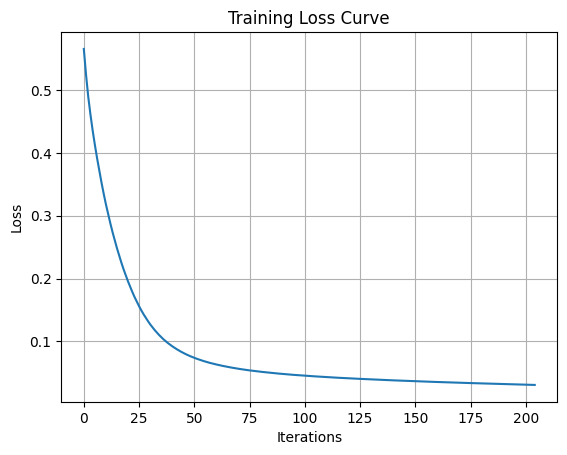

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mlp.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()